In [24]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline

import seaborn as sns 
from auxiliary import get_base_network_name
from mpl_settings_v3 import *

net_dir = '../networks/ER'

In [39]:
attack_dict = {'Ran': r'$\mathrm{Rnd}$', 'Deg': r'$\mathrm{ID}$', 'DegU': r'$\mathrm{RD}$',
               'Btw': r'$\mathrm{IB}$', 'BtwU': r'$\mathrm{RB}$', 'Eigenvector': r'$\mathrm{IE}$', 'EigenvectorU': r'$\mathrm{RE}$'}

letters = [r'$\mathrm{(a)}$', r'$\mathrm{(b)}$', r'$\mathrm{(c)}$', r'$\mathrm{(d)}$',
           r'$\mathrm{(e)}$', r'$\mathrm{(f)}$', r'$\mathrm{(g)}$', r'$\mathrm{(h)}$']

def load_dataframe(attack, size, param, net_type='ER', fast=False, n_seeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    if fast:
        base_csv_file_name = '{}_nSeeds{:d}_cpp.csv'.format(attack, n_seeds)
    else:
        base_csv_file_name = '{}_cpp.csv'.format(attack)
    csv_file_name = os.path.join(dir_name, base_net_name, base_net_name_size, base_csv_file_name)
    df = pd.read_csv(csv_file_name, index_col=0)
    return df

def load_dfs(attack, N_values, meank):

    dfs1000 = {}
    dfs10000 = {}
    dfs20000 = {}
    dfs50000 = {}
    for N in N_values:
        try:
            dfs1000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=1000)
        except:
            pass
        try:
            dfs10000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=10000)
        except:
            pass
        try:
            dfs20000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=20000)
        except:
            pass
        try:
            dfs50000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=50000)
        except:
            pass

    dfsMax = {}
    for N in N_values:
        if N in dfs50000:
            dfsMax[N] = dfs50000[N]
        elif N in dfs20000:
            dfsMax[N] = dfs20000[N]
        elif N in dfs10000:
            dfsMax[N] = dfs10000[N]
        else:
            dfsMax[N] = dfs1000[N]
            
    return dfs1000, dfs10000, dfs20000, dfsMax

def compute_fc_v2(dfs, min_f, max_f, method='beta', only_next=False, verbose=False):

    N_values = sorted(list(dfs.keys()))
    
    
    N1_over_N2 = {}
    for N in N_values:
        if method == 'beta':
            N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values
        elif method == 'binder':
            N1_over_N2[N] = dfs[N]['meanS']/(N*(dfs[N]['Sgcc']**2)).values

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for i, Na in enumerate(N_values):
        for j, Nb in enumerate(N_values):
            if Nb <= Na:
                continue
            if only_next and j != i+1:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
            inter = np.argmin(s)/max_N
            if verbose:
                print(Na, Nb, inter+min_f, sep='\t')
            inter_values.append(inter)
    mean_inter = np.mean(inter_values)
    std_inter = np.std(inter_values)
    fc = min_f + mean_inter
    return fc, std_inter

def compute_crossings(dfs, min_f, max_f, method='beta', only_next=False, verbose=False):

    N_values = sorted(list(dfs.keys()))
        
    N1_over_N2 = {}
    for N in N_values:
        if method == 'beta':
            N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values
        elif method == 'binder':
            N1_over_N2[N] = dfs[N]['meanS']/(N*(dfs[N]['Sgcc']**2)).values

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for i, Na in enumerate(N_values):
        for j, Nb in enumerate(N_values):
            if Nb <= Na:
                continue
            if only_next and j != i+1:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
            inter = np.argmin(s)/max_N
            inter_values.append([Na, Nb, inter+min_f])
            print(Na, Nb, inter+min_f, sep='\t')
            
    return inter_values

from sklearn.linear_model import LinearRegression

def getPeaks(dfs, measure):
    N_values = sorted(dfs.keys())
    
    fc_values  = []
    max_values = []
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        max_idx = df[measure].idxmax()
        max_value = df[measure][max_idx]
        
        fc_values.append(max_idx/N)
        max_values.append(max_value)
        
    return fc_values, max_values

def get_critical_measures(dfs, measure, fc):
    
    N_values = sorted(dfs.keys())
    
    if fc == 'peak':
        fc_values, _ = getPeaks(dfs, measure)
    elif isinstance(fc, float): 
        fc_values = [fc] * len(N_values)
    else:
        print('ERROR')
        
    crit_values = []    
    for i, N in enumerate(N_values):
        df = dfs[N]
        fc = fc_values[i]
            
        if measure == 'Sgcc':
            crit_values.append(N*df[measure][int(fc*N)])
        else:
            crit_values.append(df[measure][int(fc*N)])
        
    return np.array(crit_values)  

def powerlaw(X, a, c):
    return c*np.array(X)**a

def getLinearReg(sizes, values, return_r2=False):

    X = np.log(sizes)
    Y = np.log(values)
    coeffs, cov = np.polyfit(X, Y, 1, cov=True)
    errors = np.sqrt(np.diag(cov))
    
    intercept = coeffs[1]
    slope = coeffs[0]
    y_error = 3*errors[0] ## Use three times standard error
    Y_pred = intercept + X*slope
    
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope, y_error

fontsize = 26

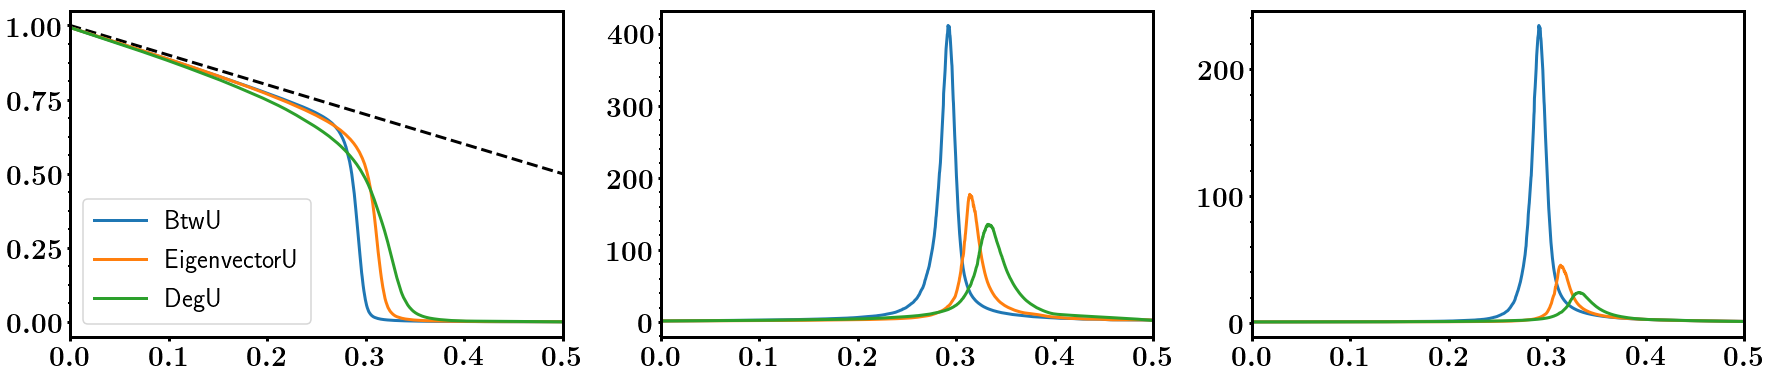

In [40]:
attacks = ['BtwU', 'EigenvectorU', 'DegU']
N_values = [1000, 2000, 4000]
param = '5.00'

dfs = {}
for attack in attacks:
    dfs[attack] = {}

    for N in N_values:
        dfs[attack][N] = load_dataframe(attack, N, param, fast=True, n_seeds=1000)

ncols = 3
fig, axes = plt.subplots(figsize=(10*ncols, 6), ncols=ncols)

for ax in axes:
    ax.set_xlim(0, 0.5)

N = 4000

ax = axes[0]
X = np.linspace(0, 1, 100)
ax.plot(X, 1-X, '--', color='k')
for attack in attacks:
    df = dfs[attack][N]
    ax.plot(df.f, df.Sgcc, label=attack)
ax.legend()

ax = axes[1]
for attack in attacks:
    df = dfs[attack][N]
    ax.plot(df.f, df.Nsec)

ax = axes[2]
for attack in attacks:
    df = dfs[attack][N]
    ax.plot(df.f, df.meanS)

plt.show()

attack		beta/nu gamma/nu      1  delta_1     tau delta_tau
Deg       	0.3192    0.3543 0.9927   0.0103  2.4739    0.0120
Btw       	0.3388    0.3365 1.0141   0.0141  2.5017    0.0150
Eigenvector	0.3314    0.3427 1.0056   0.0086  2.4916    0.0096
DegU      	0.3072    0.3773 0.9916   0.0160  2.4488    0.0177
BtwU      	0.1100    0.8714 1.0913   0.0647  2.1120    0.2283
EigenvectorU	0.2525    0.4919 0.9970   0.0478  2.3392    0.0669


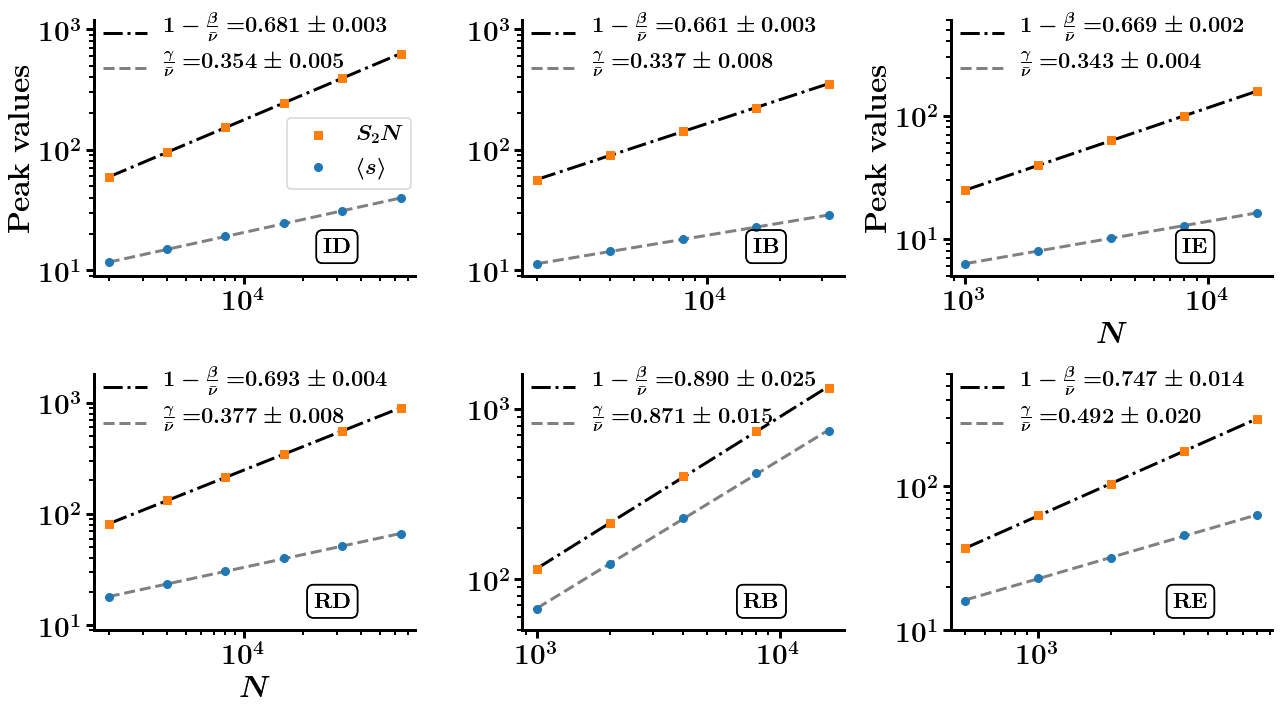

In [57]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

meank = 5
measures = ['Nsec', 'meanS']
attacks = ['Deg',  'Btw', 'Eigenvector', 'DegU', 'BtwU', 'EigenvectorU']
marker_dict = {'meanS': 'o', 'Nsec': 's'}
color_dict = {'meanS': colors[0], 'Nsec': colors[1]}
linestyle_dict = {'meanS': '--', 'Nsec': '-.'}
label_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 N$'}

print('attack\t\tbeta/nu gamma/nu      1  delta_1     tau delta_tau')

ncols = 3
nrows = 2
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()

for k, attack in enumerate(attacks):
    ax = axes[k]
    
    if attack == 'Deg':
        N_values = [2000, 4000, 8000, 16000, 32000, 64000]
        ylim = (9, 1200)
    elif attack == 'DegU':
        N_values = [2000, 4000, 8000, 16000, 32000, 64000]
        ylim = (9, 1800)
    elif attack == 'Btw':
        N_values = [2000, 4000, 8000, 16000, 32000]
        ylim = (9, 1200)
    elif attack == 'BtwU':
        N_values = [1000, 2000, 4000, 8000, 16000]
        ylim = (50, 1600)
    elif attack == 'Eigenvector':
        N_values = [1000, 2000, 4000, 8000, 16000]
        ylim = (5, 600)
    elif attack == 'EigenvectorU':
        N_values = [500, 1000, 2000, 4000, 8000]
        ylim = (10, 600)
    ax.set_ylim(ylim)
            
    dfs1000, dfs10000, dfs20000, dfsMax = load_dfs(attack, N_values, meank)
    dfs = {}
    _N_values = N_values
    for N in _N_values:
        dfs[N] = dfsMax[N]
    N_values = list(dfs.keys())

    for i, measure in enumerate(measures):

        
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='major', length=8)
    
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
        if measure == 'Nsec':
            beta_over_nu = 1 - slope
            delta_beta = y_err
        elif measure == 'meanS':
            gamma_over_nu = slope
            delta_gamma = y_err

        if k in [0, 2]:
            ax.set_ylabel(r'$\mathrm{Peak\;values}$')
        if k in [2, 3]:
            ax.set_xlabel(r'$N$')

        if measure == 'meanS':
            label = r'$\frac{\gamma}{\bar{\nu}} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
            label1 = label
            line1, = ax.plot(N_values, Y_pred, '--', color='grey', label=label)
            
        elif measure == 'Nsec':
            #label = r'$\dfrac{\gamma}{\bar{\nu}} = {{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err)
            label = r'$1 - \frac{\beta}{\bar{\nu}} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
            label2 = label
            line2, = ax.plot(N_values, Y_pred, '-.', color='k', label=label)            

        ax.set_xscale('log')
        ax.set_yscale('log')
        if k == 0:
            markers1, = ax.plot(N_values, measure_values, marker_dict[measure], 
                                color=color_dict[measure], markersize=8, label=label_dict[measure])
        else:
            markers2, = ax.plot(N_values, measure_values, marker_dict[measure],
                                color=color_dict[measure], markersize=8)
        
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.8, 0.09, attack_dict[attack], fontsize=22, 
                transform=ax.transAxes, horizontalalignment='right', bbox=bbox)
    
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    print('{:10}\t{:.4f}    {:.4f} {:.4f}   {:.4f}  {:.4f}    {:.4f}'.format(attack, beta_over_nu, gamma_over_nu, 
                                                             2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau))
        
    if k == 0:
        handles, labels = ax.get_legend_handles_labels()
        order = [1, 3]
        legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                  fontsize=22, loc=(0.6, 0.34))
        ax.add_artist(legend1)
        order = [0, 2]
        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                  fontsize=22, loc=(0.0, 0.73), frameon=False)

    else:
        ax.legend(fontsize=22, loc=(0.0, 0.73), frameon=False)

sns.despine()
plt.tight_layout()

plt.show()

KeyError: 16000

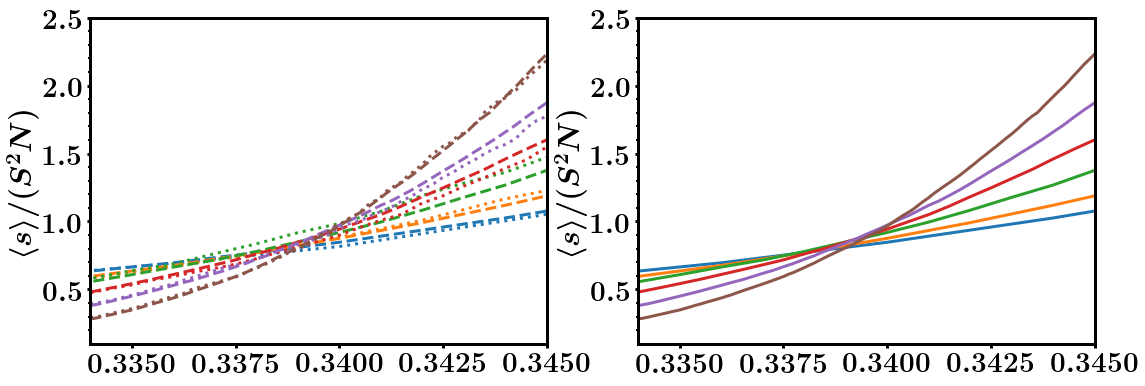

In [7]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ncols = 2
fig, axes = plt.subplots(figsize=(9*ncols, 6), ncols=ncols)

for ax in axes:
    if attack == 'Ran':
        fmin = 0.75
        fmax = 0.87
        fmin = 0.78
        fmax = 0.82
        ax.set_ylim(1, 5)
    if attack == 'Deg':
        fmin = 0.44
        fmax = 0.49
        ax.set_ylim(0.1, 4)
    if attack == 'DegU':
        fmin = 0.334
        fmax = 0.345
        ax.set_ylim(0.1, 2.5)
    if attack == 'Btw':
        fmin = 0.5
        fmax = 0.6
        ax.set_ylim(1, 30)
    ax.set_xlim(fmin, fmax)
    ax.set_ylabel(r'$\langle s \rangle/(S^2 N)$')

for i, N in enumerate(N_values):

    df = dfs1000[N]
    S1_over_S2 = df.meanS / (N*df.Sgcc**2)
    axes[0].plot(df.f, S1_over_S2, ':', color=colors[i])
    
    df = dfs10000[N]
    S1_over_S2 = df.meanS / (N*df.Sgcc**2)
    axes[0].plot(df.f, S1_over_S2, '--', label=r'${{{}}}$'.format(N), color=colors[i])
    
    try:
        df = dfs20000[N]
        S1_over_S2 = df.meanS / (N*df.Sgcc**2)
        axes[0].plot(df.f, S1_over_S2, '-', color=colors[i])
    except:
        pass
    
    df = dfsMax[N]
    S1_over_S2 = df.meanS / (N*df.Sgcc**2)
    axes[1].plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(N), color=colors[i])
    
#ax.axvline(0.8, linestyle='--', color='k')
for ax in axes:
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

dict_keys([250, 500, 1000, 2000, 4000, 8000, 16000, 32000])
0 250
1 500
2 1000
3 2000
4 4000
5 8000
6 16000
0.8011830357142858 0.004153460683636021


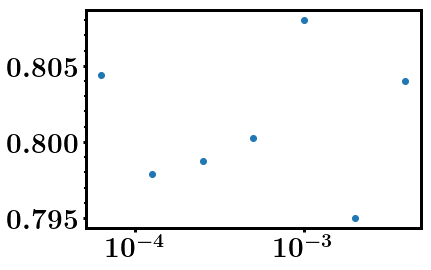

In [74]:
def compute_fc_cross(dfs, min_f, max_f, method='beta', plot=False):

    N_values = sorted(list(dfs.keys()))
    
    
    N1_over_N2 = {}
    for N in N_values:
        if method == 'beta':
            N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values
        elif method == 'binder':
            N1_over_N2[N] = dfs[N]['meanS']/(N*(dfs[N]['Sgcc']**2)).values

    inter_values = []

    for i in range(len(N_values)-1):
        
        Na = N_values[i]
        Nb = N_values[i+1]
        print(i, Na)
        
        mask = np.arange(int(min_f*Nb), int(max_f*Nb))
        Nb_values = N1_over_N2[Nb][mask]
        x = dfs[Nb].f[mask].values
        
        mask = np.arange(int(min_f*Na), int(max_f*Na))
        xp = dfs[Na].f[mask].values
        fp = N1_over_N2[Na][mask]
        Na_values = np.interp(x, xp, fp)

        inter = np.argwhere(np.diff(np.sign(Na_values - Nb_values)))[0][0]
        inter = inter/Nb + min_f
        inter_values.append(inter)
        
        if plot:
            plt.figure()
            ax = plt.gca()
            ax.plot(x, Na_values, '-o')
            ax.plot(x, Nb_values, '-o')
            ax.set_xlim(min_f, max_f)
            ax.set_ylim(2, 4)
            plt.axvline(inter, linestyle='--', color='k')
            
    inter_values = np.array(inter_values)    
    return inter_values
    
fmin = 0.334
fmax = 0.342

fmin = 0.78
fmax = 0.82

dfs = dfs10000
print(dfs.keys())
inter_values = compute_fc_cross(dfs, fmin, fmax, method='beta')
print(inter_values.mean(), inter_values.std())
fig, ax = plt.subplots()
plt.plot(1/np.array(N_values[:-1]), inter_values, 'o')
ax.set_xscale('log')
plt.show()

KeyError: 16000

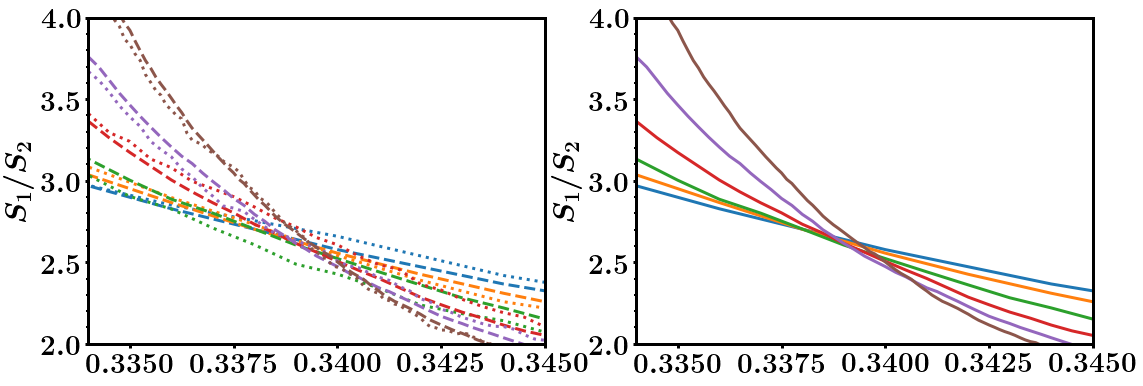

In [20]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ncols = 2
fig, axes = plt.subplots(figsize=(9*ncols, 6), ncols=ncols)

for ax in axes:
    if attack == 'Ran':
        fmin = 0.75
        fmax = 0.87
        fmin = 0.78
        fmax = 0.82
        ax.set_ylim(1, 5)
    if attack == 'Deg':
        fmin = 0.44
        fmax = 0.49
        ax.set_ylim(1.4, 4)
    if attack == 'DegU':
        fmin = 0.334
        fmax = 0.345
        ax.set_ylim(2, 4)
    if attack == 'Btw':
        fmin = 0.5
        fmax = 0.6
        ax.set_ylim(1, 3)
    ax.set_xlim(fmin, fmax)
    ax.set_ylabel(r'$S_1/S_2$')

for i, N in enumerate(N_values):

    df = dfs1000[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    axes[0].plot(df.f, S1_over_S2, ':', color=colors[i])
    
    df = dfs10000[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    axes[0].plot(df.f, S1_over_S2, '--', label=r'${{{}}}$'.format(N), color=colors[i])
    
    try:
        df = dfs20000[N]
        S1_over_S2 = N * df.Sgcc / df.Nsec
        axes[0].plot(df.f, S1_over_S2, '-', color=colors[i])
    except:
        pass
    
    df = dfsMax[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    axes[1].plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(N), color=colors[i])
    
#ax.axvline(0.8, linestyle='--', color='k')
for ax in axes:
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [12]:
def compute_fc_v2(dfs, min_f, max_f, method='beta'):

    N_values = sorted(list(dfs.keys()))
    
    
    N1_over_N2 = {}
    for N in N_values:
        if method == 'beta':
            N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values
        elif method == 'binder':
            N1_over_N2[N] = dfs[N]['meanS']/(N*(dfs[N]['Sgcc']**2)).values

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for Na in N_values:
        for Nb in N_values:
            if Nb <= Na:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
            inter = np.argmin(s)/max_N
            inter_values.append(inter)
    mean_inter = np.mean(inter_values)
    std_inter = np.std(inter_values)
    fc = min_f + mean_inter
    return fc, std_inter

print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs1000, fmin, fmax)))
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs10000, fmin, fmax)))
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs20000, fmin, fmax)))
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfsMax, fmin, fmax)))

print('Binder')
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs1000, fmin, fmax, method='binder')))
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs10000, fmin, fmax, method='binder')))
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs20000, fmin, fmax, method='binder')))
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfsMax, fmin, fmax, method='binder')))

0.4651 0.0006
0.4657 0.0006
0.4661 0.0003
0.4656 0.0003
Binder
0.4647 0.0009
0.4649 0.0002
0.4647 0.0003
0.4648 0.0002


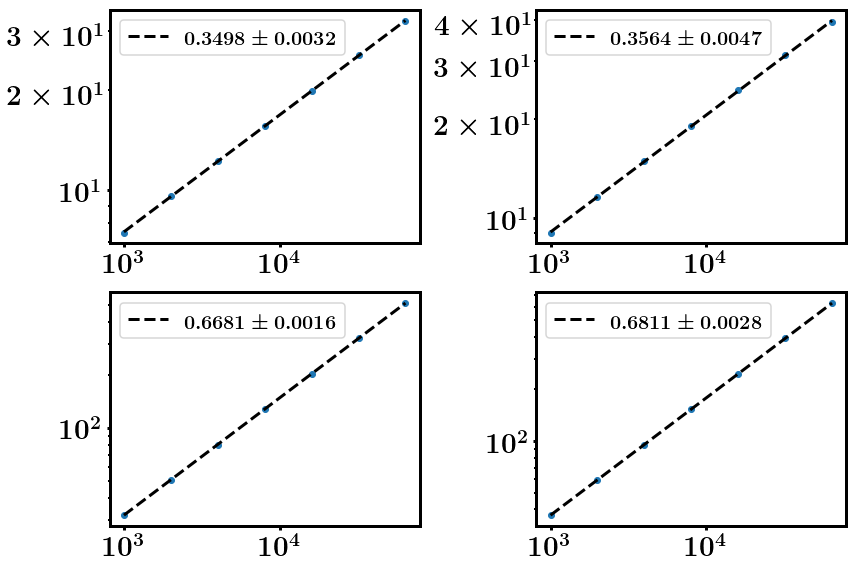

In [62]:
from sklearn.linear_model import LinearRegression

def getPeaks(dfs, measure):
    N_values = sorted(dfs.keys())
    
    fc_values  = []
    max_values = []
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        max_idx = df[measure].idxmax()
        max_value = df[measure][max_idx]
        
        fc_values.append(max_idx/N)
        max_values.append(max_value)
        
    return fc_values, max_values

def get_critical_measures(dfs, measure, fc):
    
    N_values = sorted(dfs.keys())
    
    if fc == 'peak':
        fc_values, _ = getPeaks(dfs, measure)
    elif isinstance(fc, float): 
        fc_values = [fc] * len(N_values)
    else:
        print('ERROR')
        
    crit_values = []    
    for i, N in enumerate(N_values):
        df = dfs[N]
        fc = fc_values[i]
            
        if measure == 'Sgcc':
            crit_values.append(N*df[measure][int(fc*N)])
        else:
            crit_values.append(df[measure][int(fc*N)])
        
    return np.array(crit_values)  

def powerlaw(X, a, c):
    return c*np.array(X)**a

def getLinearReg(sizes, values, return_r2=False):

    X = np.log(sizes)
    Y = np.log(values)
    coeffs, cov = np.polyfit(X, Y, 1, cov=True)
    errors = np.sqrt(np.diag(cov))
    
    intercept = coeffs[1]
    slope = coeffs[0]
    y_error = 3*errors[0] ## Use three times standard error
    Y_pred = intercept + X*slope
    
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope, y_error

dfs = copy.deepcopy(dfsMax)
del dfs[250]
del dfs[500]
#del dfs[1000]
N_values = list(dfs.keys())

fc = compute_fc_v2(dfs, fmin, fmax)[0]
#fc = 0.8

measures = ['meanS', 'Nsec']

ncols = 2
nrows = 2
fig, axes_cols = plt.subplots(figsize=(6*ncols, 4*nrows), ncols=ncols, nrows=2)

for i, measure in enumerate(measures):

    axes = axes_cols[i]
    
    measure_values = get_critical_measures(dfs, measure, fc)
    Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
    ax = axes[0]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(N_values, measure_values, 'o')
    ax.plot(N_values, Y_pred, '--', color='k', label=r'${{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err))
    ax.legend(loc='best', fontsize=20)

    measure_values = get_critical_measures(dfs, measure, fc='peak')
    Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
    ax = axes[1]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(N_values, measure_values, 'o')
    ax.plot(N_values, Y_pred, '--', color='k', label=r'${{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err))
    ax.legend(loc='best', fontsize=20)
plt.tight_layout()
plt.show()

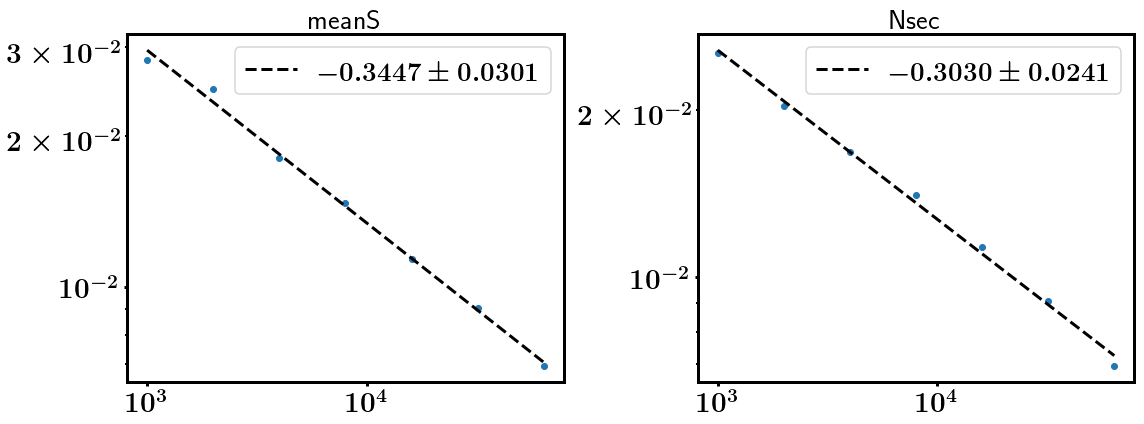

In [63]:
fig, axes = plt.subplots(figsize=(8*ncols, 6), ncols=ncols)
for i, measure in enumerate(measures):
    ax = axes[i]
    ax.set_title(measure, fontsize=28)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    fc_mean, fc_std = compute_fc_v2(dfs, fmin, fmax)
    #fc_mean = 0.465
    #fc_mean = 0.8
    fc_values, peak_values = getPeaks(dfs, measure)
    fc_diff = fc_mean - np.array(fc_values)

    ax.plot(N_values, fc_diff, 'o')
    Y_pred, slope, y_err = getLinearReg(N_values, fc_diff)
    
    ax.plot(N_values, Y_pred, '--', color='k', label=r'${{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err))
    ax.legend()
plt.tight_layout()
plt.show()

In [64]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a - b*x**(c)

curve_fit(func, N_values, fc_values, p0=[1, 1, -0.33])

(array([ 0.46785638,  0.15722494, -0.2516655 ]),
 array([[ 4.41398876e-06, -4.59220085e-05,  6.40274090e-05],
        [-4.59220085e-05,  5.16241920e-04, -6.95667243e-04],
        [ 6.40274090e-05, -6.95667243e-04,  9.51934995e-04]]))

In [65]:
fc_mean, fc_std = compute_fc_v2(dfs, fmin, fmax)
fc_values = np.linspace(fc_mean-2*fc_std, fc_mean+2*fc_std, 100)
print('{:.4f} {:.4f}'.format(fc_mean, fc_std), end='\n\n')
for i, measure in enumerate(['meanS', 'Nsec']):
    for fc in fc_values:
        measure_values = get_critical_measures(dfs, measure, fc)
        Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
        
        print('{:.5f} {:.5f} {:.5f}'.format(fc, slope, y_err))
    print()

0.4653 0.0002

0.46490 0.35215 0.00200
0.46491 0.35197 0.00194
0.46492 0.35197 0.00194
0.46492 0.35188 0.00204
0.46493 0.35188 0.00204
0.46494 0.35148 0.00191
0.46495 0.35148 0.00191
0.46496 0.35141 0.00197
0.46496 0.35141 0.00197
0.46497 0.35118 0.00180
0.46498 0.35118 0.00180
0.46499 0.35106 0.00194
0.46499 0.35106 0.00194
0.46500 0.35303 0.00264
0.46501 0.35303 0.00264
0.46502 0.35290 0.00281
0.46502 0.35290 0.00281
0.46503 0.35269 0.00282
0.46504 0.35269 0.00282
0.46505 0.35260 0.00295
0.46506 0.35260 0.00295
0.46506 0.35229 0.00292
0.46507 0.35229 0.00292
0.46508 0.35216 0.00309
0.46509 0.35216 0.00309
0.46509 0.35192 0.00308
0.46510 0.35192 0.00308
0.46511 0.35180 0.00323
0.46512 0.35180 0.00323
0.46513 0.35149 0.00301
0.46513 0.35149 0.00301
0.46514 0.35138 0.00314
0.46515 0.35138 0.00314
0.46516 0.35110 0.00318
0.46516 0.35110 0.00318
0.46517 0.35095 0.00335
0.46518 0.35095 0.00335
0.46519 0.35095 0.00335
0.46520 0.35059 0.00320
0.46520 0.35059 0.00320
0.46521 0.35050 0.00330
0

In [6]:
import igraph as ig
def getMeanK(N, minSeed, maxSeed):
    base_data_dir = '../networks/ER/ER_k5.00/ER_k5.00_N{N}'.format(N=N)
    k_values = []
    k2_values = []
    for seed in range(minSeed, maxSeed):
        network = 'ER_k5.00_N{}_{:05d}'.format(N, seed)
        file_name = os.path.join(base_data_dir, network, network + '.txt')
        g = ig.Graph().Read_Edgelist(file_name, directed=False)
        #print(data_dir)
        degSeq = np.array(g.degree())
        k_values.append(degSeq.mean())
        k2_values.append(np.mean(degSeq**2))
    k_values = np.array(k_values)
    k2_values = np.array(k2_values)
    return k_values.mean(), k2_values.mean(), k_values.std()
minSeed = 0
maxSeed = 1000
N = 8000
meank, meank2, stdk = getMeanK(N, minSeed, maxSeed)

In [7]:
print(meank, np.sqrt(meank2), stdk)

4.997051349262408 5.4740202769364625 0.03480124444828066


In [8]:
1 - 1/(meank2/meank - 1)

0.7998605398093651

In [620]:
seed = 0
N = 64000
base_data_dir = '../networks/ER/ER_k5.00/ER_k5.00_N{N}'.format(N=N)
network = 'ER_k5.00_N{}_{:05d}'.format(N, seed)
file_name = os.path.join(base_data_dir, network, network + '.txt')
g = ig.Graph().Read_Edgelist(file_name, directed=False)

btw = g.betweenness()
degSeq = g.degree()
data = list(zip(range(N), degSeq, btw))
data = np.array(data)

KeyboardInterrupt: 

15.0 4
14.0 23
13.0 34
12.0 117
11.0 253
10.0 575
9.0 1171
8.0 2042
7.0 3316
6.0 4656
5.0 5625
4.0 5604
3.0 4549
2.0 2675


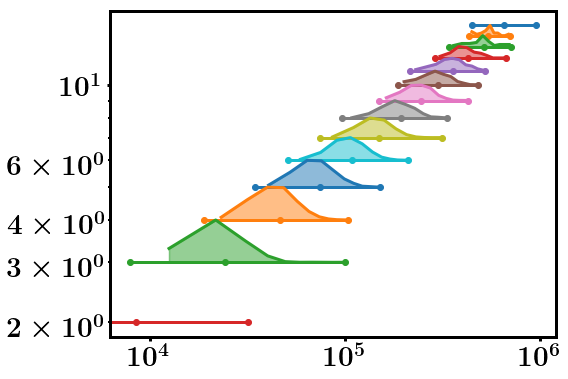

In [537]:
df = pd.DataFrame(data, columns=['id', 'k', 'b'])
fig, ax = plt.subplots(figsize=(8, 6))
#ax.set_xscale('log')
for i, k in enumerate(sorted(df.k.unique(), reverse=True)):
    if k < 2:
        continue
    color = colors[i%len(colors)]
    btw = df[df.k==k].b
    values = [btw.min(), btw.mean(), btw.max()]
    ax.plot(values, [k]*len(values), '-o', color=color)
    print(k, len(btw))
    if len(btw) > 20 and btw.min() > 0:
        hist, bin_edges = np.histogram(btw, density=True)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        ax.plot(bin_centers, (hist)/max(hist) + k, color=color)
        ax.fill_between(bin_centers, hist/max(hist)+k, k, color=color, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()    